# Assignment 2 Part Ⅱ

# Task 0: Preparation

## Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np

import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.special as scps
from statsmodels.graphics.gofplots import qqplot
from scipy.linalg import cholesky
from functools import partial
#from FMNM.probabilities import Heston_pdf, Q1, Q2
#from FMNM.cython.heston import Heston_paths_log, Heston_paths
from scipy.optimize import minimize
#from FMNM.BS_pricer import BS_pricer
#from FMNM.Parameters import Option_param
#from FMNM.Processes import Diffusion_process
from IPython.display import display
import sympy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.stats import norm
from scipy.special import gamma as gamma_func
import math
from tqdm import tqdm

sympy.init_printing()


def display_matrix(m):
    display(sympy.Matrix(m))

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as scps
from statsmodels.graphics.gofplots import qqplot
from scipy.linalg import cholesky
from functools import partial
#from FMNM.probabilities import Heston_pdf, Q1, Q2
#from FMNM.cython.heston import Heston_paths_log, Heston_paths
from scipy.optimize import minimize

from IPython.display import display
import sympy

sympy.init_printing()


def display_matrix(m):
    display(sympy.Matrix(m))

# Task 1: Monte Carlo Simulation under Heston Model

## Step 1: Simulate S and v paths

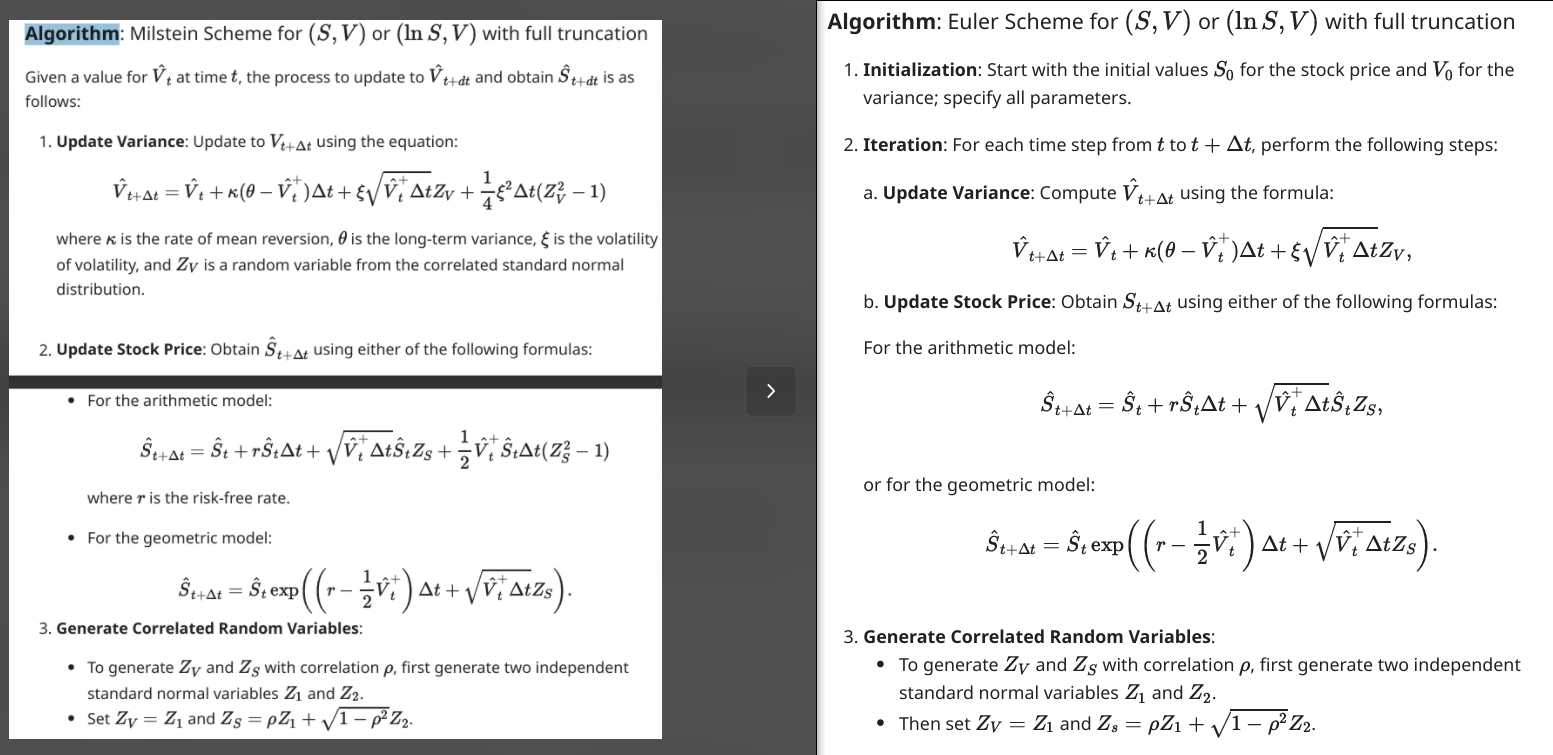

In [24]:
%%time
np.random.seed(seed=42)

N = 10000  # time steps
M = 10000  # number of paths
T = 1
T_vec, dt = np.linspace(0, T, N, retstep=True)
dt_sq = np.sqrt(dt)

S0 = 100  # spot price
X0 = np.log(S0)  # log price
v0 = 0.04  # spot variance

r = 0.05
mu = 0.1  # drift
rho = -0.2  # correlation coefficient
kappa = 2  # mean reversion coefficient
theta = 0.04  # long-term variance
xi = 0.3  # Vol of Vol - Volatility of instantaneous variance
std_asy = np.sqrt(theta * xi**2 / (2 * kappa))  # asymptotic standard deviation for the CIR process
assert 2 * kappa * theta > xi**2  # Feller condition

# Generate random Brownian Motion
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
Z = ss.multivariate_normal.rvs(mean=MU, cov=COV, size=(N - 1, M))
Z_S = Z[:, :, 0]  # Stock Brownian motion:     W_1
Z_V = Z[:, :, 1]  # Variance Brownian motion:  W_2

# Initialize vectors
S_euler = np.zeros((N, M))
V_euler = np.zeros((N, M))
S_milstein = np.zeros((N, M))
V_milstein = np.zeros((N, M))

S_euler[0, :] = S0
V_euler[0, :] = v0
S_milstein[0, :] = S0
V_milstein[0, :] = v0

v = np.zeros(N)

CPU times: total: 6.94 s
Wall time: 5.77 s


In [25]:
# Generate paths with progress bar
for t in tqdm(range(0, N - 1), desc="Simulating paths"):
    # Euler:
    Vt_e = np.maximum(V_euler[t, :], 0)
    sqrt_V_e = np.sqrt(Vt_e)

    V_euler[t + 1, :] = V_euler[t, :] + kappa * (theta - Vt_e) * dt + xi * sqrt_V_e * dt_sq * Z_V[t, :]
    V_euler[t + 1, :] = np.abs(V_euler[t + 1, :])

    S_euler[t + 1, :] = S_euler[t, :] + r * S_euler[t, :] * dt + sqrt_V_e * dt_sq * S_euler[t, :] * Z_S[t, :]

    # Milstein:
    Vt_m = np.maximum(V_milstein[t, :], 0)
    sqrt_V_m = np.sqrt(Vt_m)

    V_milstein[t + 1, :] = V_milstein[t, :] + kappa * (theta - Vt_m) * dt + xi * sqrt_V_m * dt_sq * Z_V[t, :] + 0.25 * xi**2 * dt * (Z_V[t, :]**2 - 1)
    V_milstein[t + 1, :] = np.abs(V_milstein[t + 1, :])

    S_milstein[t + 1, :] = S_milstein[t, :] + r * S_milstein[t, :] * dt + sqrt_V_m * dt_sq * S_milstein[t, :] * Z_S[t, :] + 0.5 * Vt_m * S_milstein[t, :] * dt * (Z_S[t, :]**2 - 1)

Simulating paths: 100%|██████████████████████████████████████████████████████████| 9999/9999 [00:04<00:00, 2159.42it/s]


CPU times: total: 12.5 s
Wall time: 11.4 s


### Plot Stock Prices Paths

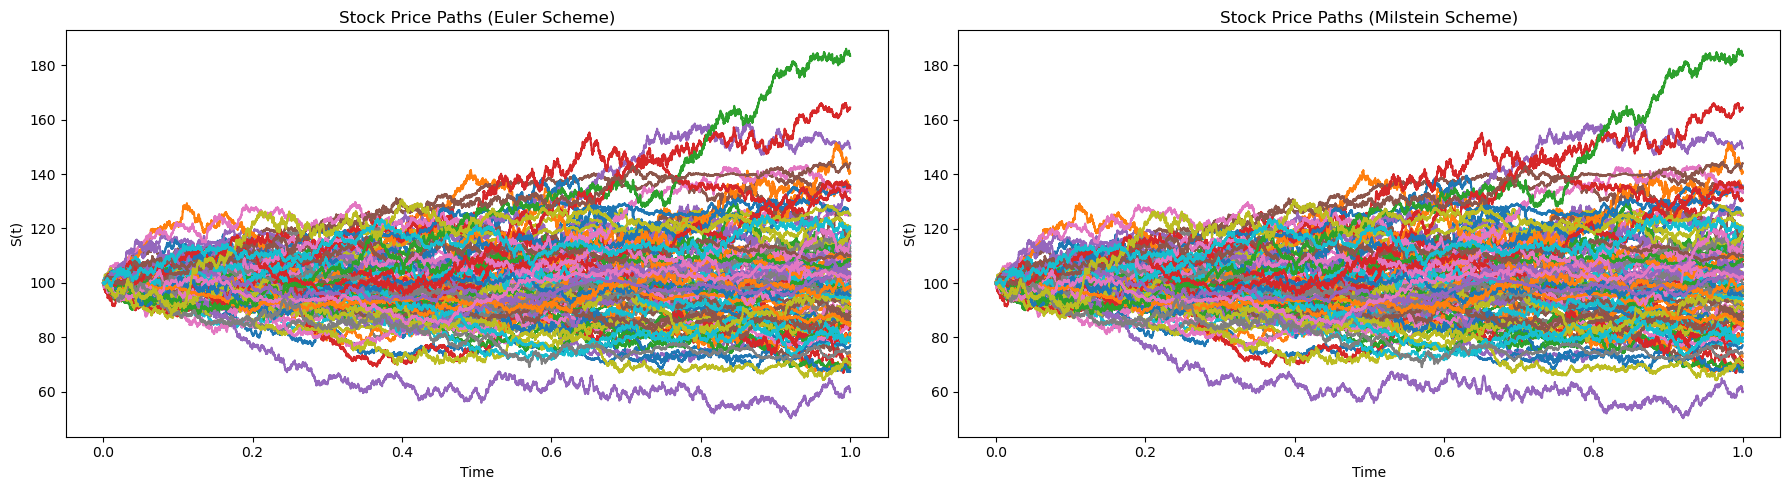

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(T_vec, S_euler[:, :100])
ax1.set_title("Stock Price Paths (Euler Scheme)")
ax1.set_xlabel("Time")
ax1.set_ylabel("S(t)")

ax2.plot(T_vec, S_milstein[:, :100])
ax2.set_title("Stock Price Paths (Milstein Scheme)")
ax2.set_xlabel("Time")
ax2.set_ylabel("S(t)")

plt.tight_layout()
plt.show()

### Plot Variance Paths

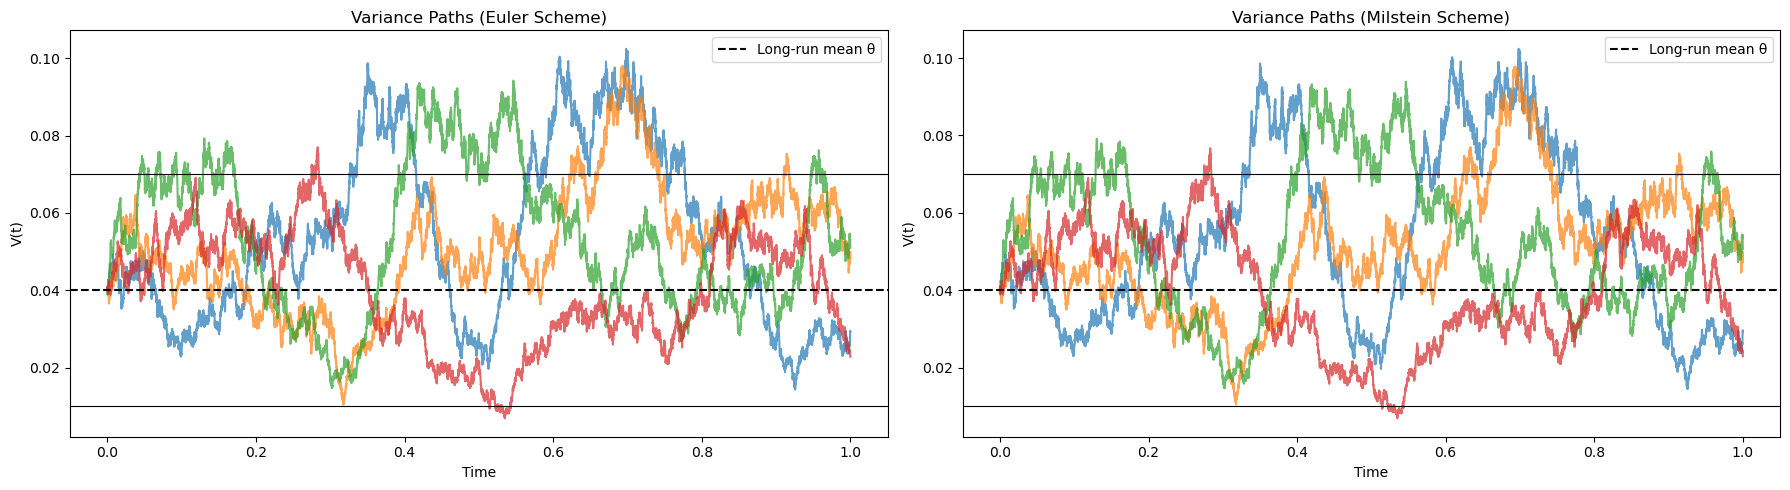

In [23]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(18, 5))

ax3.plot(T_vec, V_euler[:, :4], alpha=0.7)
ax3.set_title("Variance Paths (Euler Scheme)")
ax3.set_xlabel("Time")
ax3.set_ylabel("V(t)")
ax3.axhline(theta, color="black", linestyle="--", label="Long-run mean θ")
ax3.axhline(theta + std_asy, color="black", linewidth=0.8)
ax3.axhline(theta - std_asy, color="black", linewidth=0.8)
ax3.legend()

ax4.plot(T_vec, V_milstein[:, :4], alpha=0.7)
ax4.set_title("Variance Paths (Milstein Scheme)")
ax4.set_xlabel("Time")
ax4.set_ylabel("V(t)")
ax4.axhline(theta, color="black", linestyle="--", label="Long-run mean θ")
ax4.axhline(theta + std_asy, color="black", linewidth=0.8)
ax4.axhline(theta - std_asy, color="black", linewidth=0.8)
ax4.legend()

plt.tight_layout()
plt.show()

## Step2: Calculate the arithmetic average price along each path and the corresponding option payoff.

In [74]:
K = 100
avg_price_euler = np.mean(S_euler[1:, :], axis=0)
avg_price_milstein = np.mean(S_milstein[1:, :], axis=0)
payoff_euler = np.maximum(avg_price_euler - K, 0)
payoff_milstein = np.maximum(avg_price_milstein - K, 0)

## Step3: Compute the Monte Carlo estimator and its standard error using M simulated paths. Compare Euler versus Milstein scheme

In [77]:
price_euler = np.exp(-r * T) * np.mean(payoff_euler)
std_euler = np.std(np.exp(-r * T) * payoff_euler) / np.sqrt(M)

price_milstein = np.exp(-r * T) * np.mean(payoff_milstein)
std_milstein = np.std(np.exp(-r * T) * payoff_milstein) / np.sqrt(M)

## Step4: Verify your implementation by temporarily setting volatility-of-volatility ξ = 0 (reducing Heston to GBM) and comparing your results against known or approximated benchmarks

In [25]:
%%time
np.random.seed(seed=42)

xi = 0  # Vol of Vol - Volatility of instantaneous variance

S_euler_null = np.zeros((N, M))
V_euler_null = np.zeros((N, M))
S_milstein_null = np.zeros((N, M))
V_milstein_null = np.zeros((N, M))

S_euler_null[0, :] = S0
V_euler_null[0, :] = v0
S_milstein_null[0, :] = S0
V_milstein_null[0, :] = v0

for t in tqdm(range(0, N - 1), desc="Simulating paths"):
    # Euler:
    Vt_e = np.maximum(V_euler_null[t, :], 0)
    sqrt_V_e = np.sqrt(Vt_e)

    V_euler_null[t + 1, :] = V_euler_null[t, :] + kappa * (theta - Vt_e) * dt + xi * sqrt_V_e * dt_sq * Z_V[t, :]
    V_euler_null[t + 1, :] = np.abs(V_euler_null[t + 1, :])

    S_euler_null[t + 1, :] = S_euler_null[t, :] + r * S_euler_null[t, :] * dt + sqrt_V_e * dt_sq * S_euler_null[t, :] * Z_S[t, :]

    # Milstein:
    Vt_m = np.maximum(V_milstein_null[t, :], 0)
    sqrt_V_m = np.sqrt(Vt_m)

    V_milstein_null[t + 1, :] = V_milstein_null[t, :] + kappa * (theta - Vt_m) * dt + xi * sqrt_V_m * dt_sq * Z_V[t, :] + 0.25 * xi**2 * dt * (Z_V[t, :]**2 - 1)
    V_milstein_null[t + 1, :] = np.abs(V_milstein_null[t + 1, :])

    S_milstein_null[t + 1, :] = S_milstein_null[t, :] + r * S_milstein_null[t, :] * dt + sqrt_V_m * dt_sq * S_milstein_null[t, :] * Z_S[t, :] + 0.5 * Vt_m * S_milstein_null[t, :] * dt * (Z_S[t, :]**2 - 1)

Simulating paths: 100%|██████████████████████████████████████████████████████████| 9999/9999 [00:05<00:00, 1725.84it/s]

CPU times: total: 5.23 s
Wall time: 5.8 s


In [26]:
avg_price_euler_null = np.mean(S_euler_null[1:, :], axis=0)
avg_price_milstein_null = np.mean(S_milstein_null[1:, :], axis=0)
payoff_euler_null = np.maximum(avg_price_euler_null - K, 0)
payoff_milstein_null = np.maximum(avg_price_milstein_null - K, 0)

price_euler_null = np.exp(-r * T) * np.mean(payoff_euler_null)
std_euler_null = np.std(np.exp(-r * T) * payoff_euler_null) / np.sqrt(M)
price_milstein_null = np.exp(-r * T) * np.mean(payoff_milstein_null)
std_milstein_null = np.std(np.exp(-r * T) * payoff_milstein_null) / np.sqrt(M)

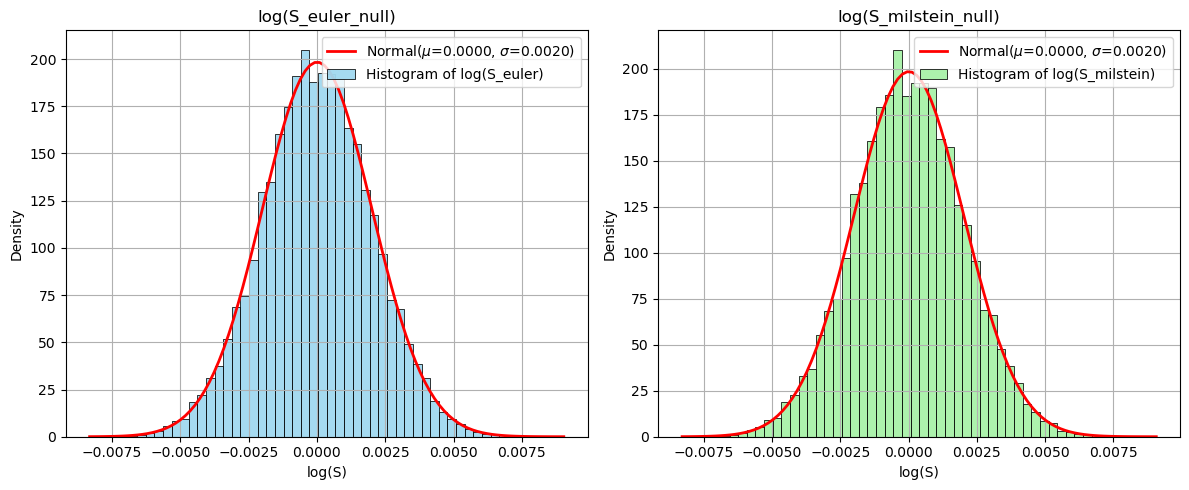

In [31]:
log_S_euler = np.log(S_euler_null[1, :]/S_euler_null[0, :])
log_S_milstein = np.log(S_milstein_null[1, :]/S_milstein_null[0, :])

mu_euler = np.mean(log_S_euler)
std_euler = np.std(log_S_euler)
mu_milstein = np.mean(log_S_milstein)
std_milstein = np.std(log_S_milstein)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(log_S_euler, bins=50, kde=False, stat="density", color="skyblue", label="Histogram of log(S_euler)")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_euler, std_euler)
plt.plot(x, p, 'r', linewidth=2, label=f"Normal($\\mu$={mu_euler:.4f}, $\\sigma$={std_euler:.4f})")
plt.title("log(S_euler_null)")
plt.xlabel("log(S)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(log_S_milstein, bins=50, kde=False, stat="density", color="lightgreen", label="Histogram of log(S_milstein)")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_milstein, std_milstein)
plt.plot(x, p, 'r', linewidth=2, label=f"Normal($\\mu$={mu_milstein:.4f}, $\\sigma$={std_milstein:.4f})")
plt.title("log(S_milstein_null)")
plt.xlabel("log(S)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## TASK1 RESULTS:

In [78]:
df = pd.DataFrame([
        {"Method": "Euler (Heston)", "Price": price_euler, "Std Error": std_euler},
        {"Method": "Milstein (Heston)", "Price": price_milstein, "Std Error": std_milstein},
        {"Method": "Euler (GBM, ξ=0)", "Price": price_euler_null, "Std Error": std_euler_null},
        {"Method": "Milstein (GBM, ξ=0)", "Price": price_milstein_null, "Std Error": std_milstein_null}
    ])
print(df)

                Method     Price  Std Error
0       Euler (Heston)  5.583766   0.076201
1    Milstein (Heston)  5.584209   0.076207
2     Euler (GBM, ξ=0)  5.641262   0.078666
3  Milstein (GBM, ξ=0)  5.641433   0.078668


# Task 2: Analytical Geometric-Asian Price as Control Variate Reference

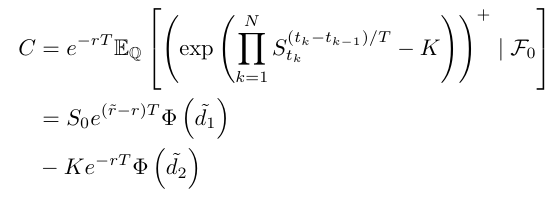
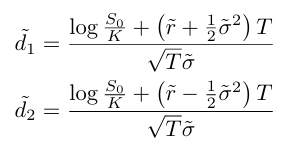
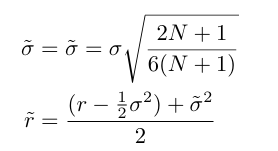

## Step1: Choose and justify a suitable volatility σ for the GBM control variate.

In [81]:
sigma = np.sqrt(theta)

## Step2: Calculate the geometric Asian option price analytically using the provided closed-form solution.

In [82]:
sigma_sq = sigma**2
sigma_tilde = sigma * np.sqrt((2 * N + 1) / (6 * (N + 1)))
r_tilde = 0.5 * (r - 0.5 * sigma_sq + 0.5 * sigma_tilde**2)

d1 = (np.log(S0 / K) + (r_tilde + 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))
d2 = d1 - sigma_tilde * np.sqrt(T)
price = S0 * np.exp((r_tilde - r) * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
print(price)

5.35541903897726


## Step3: Test your implementation on known scenarios to ensure accuracy

# Task 3: Implementing the Control Variate Monte Carlo

## Step1: Simulate parallel Black–Scholes (GBM) paths using identical Brownian increments from the Heston paths.

## Step2: Compute arithmetic-average Asian payoffs (Heston) and geometric-average Asian payoffs (GBM) simultaneously.

In [83]:
log_S_gbm_euler = np.log(S_euler_null[1:, :])
geo_avg_gbm_euler = np.exp(np.mean(log_S_gbm_euler, axis=0))
payoff_gbm_geo_euler = np.maximum(geo_avg_gbm_euler - K, 0)

log_S_gbm_milstein = np.log(S_milstein_null[1:, :])
geo_avg_gbm_milstein = np.exp(np.mean(log_S_gbm_milstein, axis=0))
payoff_gbm_geo_milstein = np.maximum(geo_avg_gbm_milstein - K, 0)

## Step3: Use the control variate estimator with initially choosing c = 1.

In [84]:
Y_bar_euler = np.mean(payoff_euler)
Y_bar_milstein = np.mean(payoff_milstein)
X_bar_euler = np.mean(payoff_gbm_geo_euler)
X_bar_milstein = np.mean(payoff_gbm_geo_milstein)
C_G = price
c = 1
C_CV1 = Y_bar_euler + c * (C_G - X_bar_euler)
C_CV2 = Y_bar_milstein + c * (C_G - X_bar_milstein)
print(C_CV1,C_CV2)

5.514873461328379 5.5151685565705115


## Step4: Compute variance and standard error of both the plain and control variate estimators, and compare their performance

In [85]:
var_cv1 = np.var(np.exp(-r * T) * (payoff_euler + c * (C_G - payoff_gbm_geo_euler))) / M
var_cv2 = np.var(np.exp(-r * T) * (payoff_milstein + c * (C_G - payoff_gbm_geo_milstein))) / M
print(var_cv1,var_cv2)

std_cv1 = np.std(np.exp(-r * T) * (payoff_euler + c * (C_G - payoff_gbm_geo_euler))) / np.sqrt(M)
std_cv2 = np.std(np.exp(-r * T) * (payoff_milstein + c * (C_G - payoff_gbm_geo_milstein))) / np.sqrt(M)
print(std_cv1,std_cv2)

0.0005622244808663589 0.0005621505219323425
0.02371127328648462 0.023709713661964425


In [86]:
df_2 = pd.DataFrame([
        {"Method": "Euler (Heston)", "Price": price_euler, "Std Error": std_euler},
        {"Method": "Milstein (Heston)", "Price": price_milstein, "Std Error": std_milstein},
        {"Method": "Control Variate-Euler", "Price": np.exp(-r * T) * C_CV1, "Std Error": std_cv1},
        {"Method": "Control Variate-Milstein", "Price": np.exp(-r * T) * C_CV2, "Std Error": std_cv2}
    ])
print(df_2)

                     Method     Price  Std Error
0            Euler (Heston)  5.583766   0.076201
1         Milstein (Heston)  5.584209   0.076207
2     Control Variate-Euler  5.245910   0.023711
3  Control Variate-Milstein  5.246191   0.023710


# Task 4: Experiments and Comparative Analysis

## Monte Carlo Function

In [3]:
def MC(M_values, N_values, xi_values, rho_values, K_values):
    
    M = M_values  # number of paths
    N = N_values  # time steps
    
    xi = xi_values
    rho = rho_values
    K = K_values
    
    T = 1
    T_vec, dt = np.linspace(0, T, N, retstep=True)
    dt_sq = np.sqrt(dt)
    
    S0 = 100  # spot price
    X0 = np.log(S0)  # log price
    v0 = 0.04  # spot variance
    
    r = 0.05
    mu = 0.1  # drift
    rho = -0.2  # correlation coefficient
    kappa = 2  # mean reversion coefficient
    theta = 0.04  # long-term variance
    xi = 0.3  # Vol of Vol - Volatility of instantaneous variance
    std_asy = np.sqrt(theta * xi**2 / (2 * kappa))  # asymptotic standard deviation for the CIR process
    assert 2 * kappa * theta > xi**2  # Feller condition
    
    # Generate random Brownian Motion
    MU = np.array([0, 0])
    COV = np.matrix([[1, rho], [rho, 1]])
    Z = ss.multivariate_normal.rvs(mean=MU, cov=COV, size=(N - 1, M))
    Z_S = Z[:, :, 0]  # Stock Brownian motion:     W_1
    Z_V = Z[:, :, 1]  # Variance Brownian motion:  W_2
    
    # Initialize vectors
    S_euler = np.zeros((N, M))
    V_euler = np.zeros((N, M))
    S_milstein = np.zeros((N, M))
    V_milstein = np.zeros((N, M))
    
    S_euler[0, :] = S0
    V_euler[0, :] = v0
    S_milstein[0, :] = S0
    V_milstein[0, :] = v0
    
    v = np.zeros(N)

    S_euler_null = np.zeros((N, M))
    V_euler_null = np.zeros((N, M))
    S_milstein_null = np.zeros((N, M))
    V_milstein_null = np.zeros((N, M))
    
    S_euler_null[0, :] = S0
    V_euler_null[0, :] = v0
    S_milstein_null[0, :] = S0
    V_milstein_null[0, :] = v0

    results = []
    # Step1: Simulation: Euler;Milstein;GBM
    for t in tqdm(range(0, N - 1), desc="Simulating paths"):
        # Euler:
        Vt_e = np.maximum(V_euler[t, :], 0)
        sqrt_V_e = np.sqrt(Vt_e)
        V_euler[t + 1, :] = V_euler[t, :] + kappa * (theta - Vt_e) * dt + xi * sqrt_V_e * dt_sq * Z_V[t, :]
        V_euler[t + 1, :] = np.abs(V_euler[t + 1, :])
        S_euler[t + 1, :] = S_euler[t, :] + r * S_euler[t, :] * dt + sqrt_V_e * dt_sq * S_euler[t, :] * Z_S[t, :]
    
        # Milstein:
        Vt_m = np.maximum(V_milstein[t, :], 0)
        sqrt_V_m = np.sqrt(Vt_m)
        V_milstein[t + 1, :] = V_milstein[t, :] + kappa * (theta - Vt_m) * dt + xi * sqrt_V_m * dt_sq * Z_V[t, :] + 0.25 * xi**2 * dt * (Z_V[t, :]**2 - 1)
        V_milstein[t + 1, :] = np.abs(V_milstein[t + 1, :])
        S_milstein[t + 1, :] = S_milstein[t, :] + r * S_milstein[t, :] * dt + sqrt_V_m * dt_sq * S_milstein[t, :] * Z_S[t, :] + 0.5 * Vt_m * S_milstein[t, :] * dt * (Z_S[t, :]**2 - 1)
    
        # GBM:
        V_euler_null[t + 1, :] = V_euler_null[t, :] + kappa * (theta - Vt_e) * dt
        V_euler_null[t + 1, :] = np.abs(V_euler_null[t + 1, :])
        S_euler_null[t + 1, :] = S_euler_null[t, :] + r * S_euler_null[t, :] * dt + sqrt_V_e * dt_sq * S_euler_null[t, :] * Z_S[t, :]
    
        V_milstein_null[t + 1, :] = V_milstein_null[t, :] + kappa * (theta - Vt_m) * dt
        V_milstein_null[t + 1, :] = np.abs(V_milstein_null[t + 1, :])
        S_milstein_null[t + 1, :] = S_milstein_null[t, :] + r * S_milstein_null[t, :] * dt + sqrt_V_m * dt_sq * S_milstein_null[t, :] * Z_S[t, :] + 0.5 * Vt_m * S_milstein_null[t, :] * dt * (Z_S[t, :]**2 - 1)


    # Step2: Compute arithmetic Prices and Payoffs
    avg_price_euler = np.mean(S_euler[1:, :], axis=0)
    avg_price_milstein = np.mean(S_milstein[1:, :], axis=0)
    payoff_euler = np.maximum(avg_price_euler - K, 0)
    payoff_milstein = np.maximum(avg_price_milstein - K, 0)


    # Step3: Compute rude MC estimator:
    price_euler_rMC = np.exp(-r * T) * np.mean(payoff_euler)
    std_euler_rMC = np.std(np.exp(-r * T) * payoff_euler) / np.sqrt(M)
    
    price_milstein_rMC = np.exp(-r * T) * np.mean(payoff_milstein)
    std_milstein_rMC = np.std(np.exp(-r * T) * payoff_milstein) / np.sqrt(M)


    # Step4: Compute geometric Prices and Payoffs
    sigma = np.sqrt(theta)
    sigma_sq = sigma**2
    sigma_tilde = sigma * np.sqrt((2 * N + 1) / (6 * (N + 1)))
    r_tilde = 0.5 * (r - 0.5 * sigma_sq + 0.5 * sigma_tilde**2)
    
    d1 = (np.log(S0 / K) + (r_tilde + 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))
    d2 = d1 - sigma_tilde * np.sqrt(T)
    price_geo = S0 * np.exp((r_tilde - r) * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    log_S_gbm_euler = np.log(S_euler_null[1:, :])
    geo_avg_gbm_euler = np.exp(np.mean(log_S_gbm_euler, axis=0))
    payoff_gbm_geo_euler = np.maximum(geo_avg_gbm_euler - K, 0)
    
    log_S_gbm_milstein = np.log(S_milstein_null[1:, :])
    geo_avg_gbm_milstein = np.exp(np.mean(log_S_gbm_milstein, axis=0))
    payoff_gbm_geo_milstein = np.maximum(geo_avg_gbm_milstein - K, 0)
    
    
    # Step5: Compute control variate MC:
    Y_bar_euler = np.mean(payoff_euler)
    Y_bar_milstein = np.mean(payoff_milstein)
    X_bar_euler = np.mean(payoff_gbm_geo_euler)
    X_bar_milstein = np.mean(payoff_gbm_geo_milstein)
    C_G = price_geo
    c = 1
    
    price_euler_cvMC = np.exp(-r * T) * (Y_bar_euler + c * (C_G - X_bar_euler))
    std_euler_cvMC = np.std(np.exp(-r * T) * (payoff_euler + c * (C_G - payoff_gbm_geo_euler))) / np.sqrt(M)
    
    price_milstein_cvMC = np.exp(-r * T) * (Y_bar_milstein + c * (C_G - X_bar_milstein))
    std_milstein_cvMC = np.std(np.exp(-r * T) * (payoff_milstein + c * (C_G - payoff_gbm_geo_milstein))) / np.sqrt(M)


    # Step6: Print results:
    results = pd.DataFrame([
        {"Method": "Rude MC estimator-Euler (Heston)", "Price": price_euler_rMC, "Std Error": std_euler_rMC},
        {"Method": "Rude MC estimator-Milstein (Heston)", "Price": price_milstein_rMC, "Std Error": std_milstein_rMC},
        {"Method": "Control Variate MC estimator-Euler", "Price": price_euler_cvMC, "Std Error": std_euler_cvMC},
        {"Method": "Control Variate MC estimator-Milstein", "Price": price_milstein_cvMC, "Std Error": std_milstein_cvMC}
    ])
    
    return results

### Function test:

In [4]:
np.random.seed(seed=42)

MC(10,10,0.3,-0.2,100)

Simulating paths: 100%|████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 3246.09it/s]


,Method,Price,Std Error
0,Rude MC estimator-Euler (Heston),6.891045,2.524797
1,Rude MC estimator-Milstein (Heston),6.744303,2.438804
2,Control Variate MC estimator-Euler,5.284477,0.123599
3,Control Variate MC estimator-Milstein,5.285184,0.114961


## (a): Variance Reduction Efficacy----across various numbers of M

In [9]:
M_values = [1000, 2000, 5000, 10000]
results_list_M = []

for M in M_values:
    result = MC(M, 10000, 0.3, -0.2, 100)
    result["M"] = M
    results_list_M.append(result)

df_M = pd.concat(results_list_M)
print(df_M)

Simulating paths: 100%|███████████████████████████████████████████████████████████| 9999/9999 [00:35<00:00, 285.65it/s]


                                  Method     Price  Std Error      M
0       Rude MC estimator-Euler (Heston)  5.820802   0.250493   1000
1    Rude MC estimator-Milstein (Heston)  5.820927   0.250472   1000
2     Control Variate MC estimator-Euler  5.299760   0.010552   1000
3  Control Variate MC estimator-Milstein  5.299736   0.010551   1000
0       Rude MC estimator-Euler (Heston)  5.287673   0.159565   2000
1    Rude MC estimator-Milstein (Heston)  5.287950   0.159566   2000
2     Control Variate MC estimator-Euler  5.272104   0.006675   2000
3  Control Variate MC estimator-Milstein  5.272101   0.006672   2000
0       Rude MC estimator-Euler (Heston)  5.668931   0.108717   5000
1    Rude MC estimator-Milstein (Heston)  5.669418   0.108722   5000
2     Control Variate MC estimator-Euler  5.299840   0.005158   5000
3  Control Variate MC estimator-Milstein  5.299911   0.005159   5000
0       Rude MC estimator-Euler (Heston)  5.634651   0.077002  10000
1    Rude MC estimator-Milstein (H

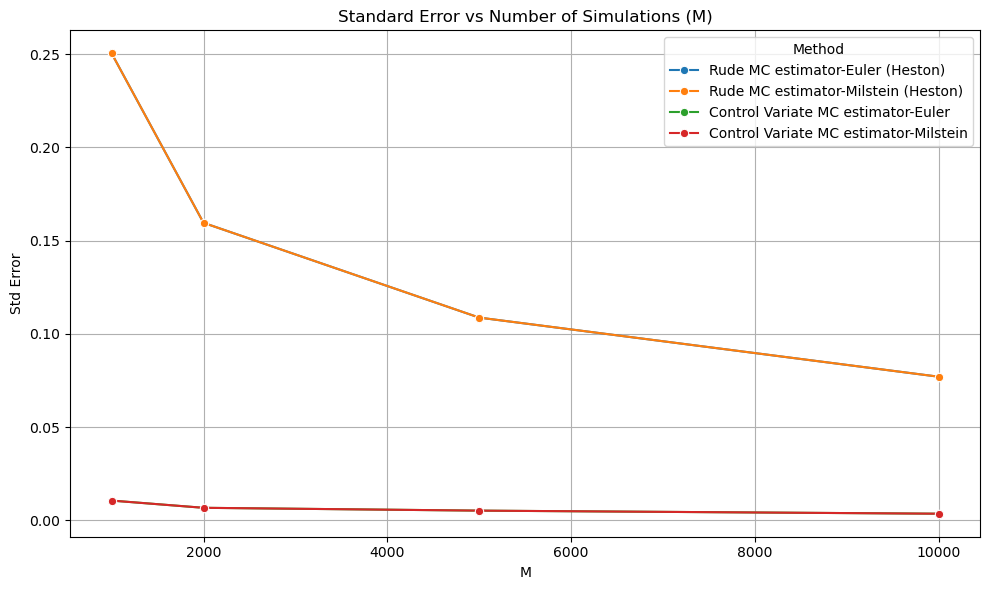

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_M, x="M", y="Std Error", hue="Method", marker="o")
plt.title("Standard Error vs Number of Simulations (M)")
plt.grid(True)
plt.tight_layout()
plt.show()

## (b): Impact of Varying Heston Parameters: xi;rho;K

### Volatility-of-volatility ξ: Compare low (ξ = 0.1) and high (ξ = 1.0) scenarios

In [12]:
xi_values = [0.1, 1]
results_list_xi = []

for xi in xi_values:
    result = MC(10000, 10000, xi, -0.2, 100)
    result["xi"] = xi
    results_list_xi.append(result)

df_xi = pd.concat(results_list_xi)
print(df_xi)

Simulating paths: 100%|███████████████████████████████████████████████████████████| 9999/9999 [00:58<00:00, 169.48it/s]


                                  Method     Price  Std Error   xi
0       Rude MC estimator-Euler (Heston)  5.749270   0.076635  0.1
1    Rude MC estimator-Milstein (Heston)  5.748796   0.076625  0.1
2     Control Variate MC estimator-Euler  5.293903   0.003371  0.1
3  Control Variate MC estimator-Milstein  5.293894   0.003369  0.1
0       Rude MC estimator-Euler (Heston)  5.731810   0.076901  1.0
1    Rude MC estimator-Milstein (Heston)  5.731494   0.076901  1.0
2     Control Variate MC estimator-Euler  5.295255   0.003455  1.0
3  Control Variate MC estimator-Milstein  5.295249   0.003455  1.0


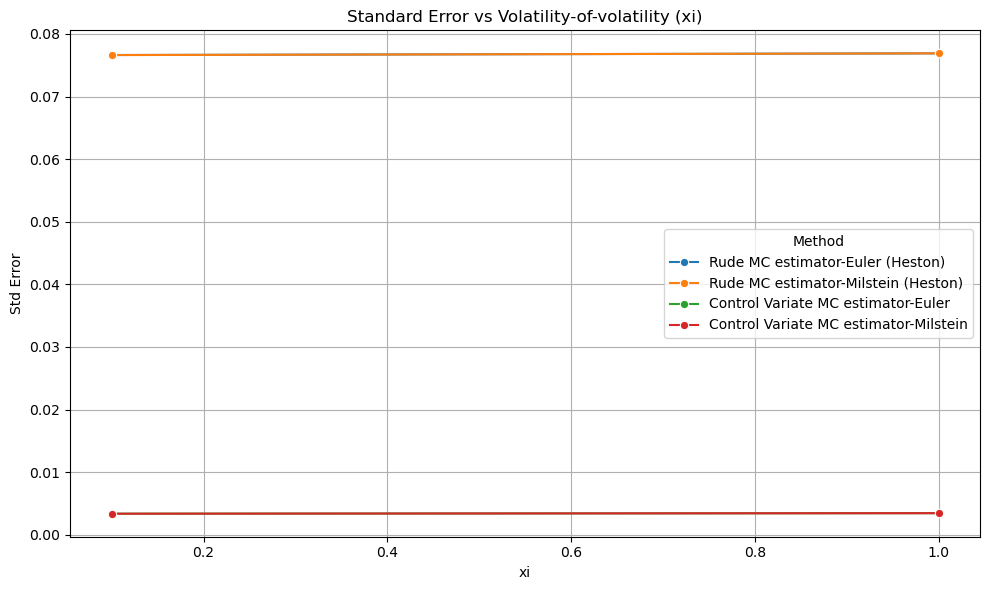

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_xi, x="xi", y="Std Error", hue="Method", marker="o")
plt.title("Standard Error vs Volatility-of-volatility (xi)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Correlation ρ: Evaluate negative correlation (ρ = −0.9) versus zero or positive correlation (ρ = 0 or 0.5).

In [13]:
rho_values = [-0.9, 0, 0.5]
results_list_rho = []

for rho in rho_values:
    result = MC(10000, 10000, 0.3, rho, 100)
    result["rho"] = rho
    results_list_rho.append(result)

df_rho = pd.concat(results_list_rho)
print(df_rho)

Simulating paths: 100%|███████████████████████████████████████████████████████████| 9999/9999 [00:33<00:00, 297.76it/s]


                                  Method     Price  Std Error  rho
0       Rude MC estimator-Euler (Heston)  5.618053   0.076484 -0.9
1    Rude MC estimator-Milstein (Heston)  5.618347   0.076490 -0.9
2     Control Variate MC estimator-Euler  5.291262   0.003406 -0.9
3  Control Variate MC estimator-Milstein  5.291294   0.003407 -0.9
0       Rude MC estimator-Euler (Heston)  5.740027   0.077093  0.0
1    Rude MC estimator-Milstein (Heston)  5.740041   0.077092  0.0
2     Control Variate MC estimator-Euler  5.298447   0.003524  0.0
3  Control Variate MC estimator-Milstein  5.298473   0.003525  0.0
0       Rude MC estimator-Euler (Heston)  5.712086   0.075572  0.5
1    Rude MC estimator-Milstein (Heston)  5.712140   0.075575  0.5
2     Control Variate MC estimator-Euler  5.294695   0.003598  0.5
3  Control Variate MC estimator-Milstein  5.294719   0.003598  0.5


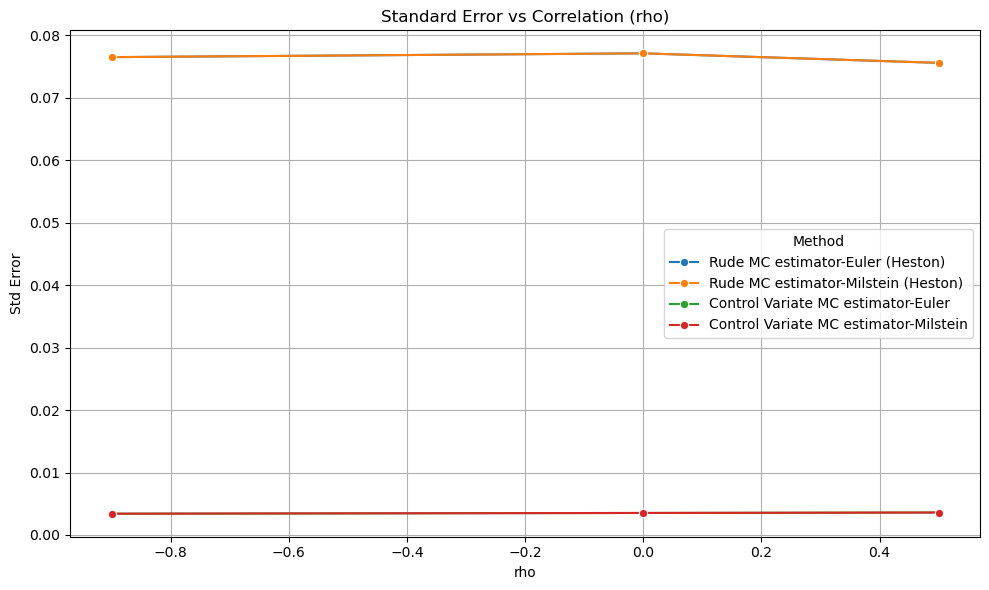

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_rho, x="rho", y="Std Error", hue="Method", marker="o")
plt.title("Standard Error vs Correlation (rho)")
plt.grid(True)
plt.tight_layout()
plt.show()

###  Strike K: Analyze in-the-money (K < S0), at-the-money (K ≈ S0), and out-of-the-money (K > S0) cases

In [14]:
K_values = [90, 100, 110]
results_list_K = []

for K in K_values:
    result = MC(10000, 10000, 0.3, -0.2, K)
    result["K"] = K
    results_list_K.append(result)

df_K = pd.concat(results_list_K)
print(df_K)

Simulating paths: 100%|███████████████████████████████████████████████████████████| 9999/9999 [00:52<00:00, 191.99it/s]


                                  Method      Price  Std Error    K
0       Rude MC estimator-Euler (Heston)  12.675929   0.100140   90
1    Rude MC estimator-Milstein (Heston)  12.676029   0.100142   90
2     Control Variate MC estimator-Euler  11.705515   0.003497   90
3  Control Variate MC estimator-Milstein  11.705533   0.003497   90
0       Rude MC estimator-Euler (Heston)   5.775280   0.078244  100
1    Rude MC estimator-Milstein (Heston)   5.775312   0.078247  100
2     Control Variate MC estimator-Euler   5.301896   0.003635  100
3  Control Variate MC estimator-Milstein   5.301906   0.003635  100
0       Rude MC estimator-Euler (Heston)   1.821510   0.045742  110
1    Rude MC estimator-Milstein (Heston)   1.821461   0.045741  110
2     Control Variate MC estimator-Euler   1.798155   0.003281  110
3  Control Variate MC estimator-Milstein   1.798144   0.003281  110


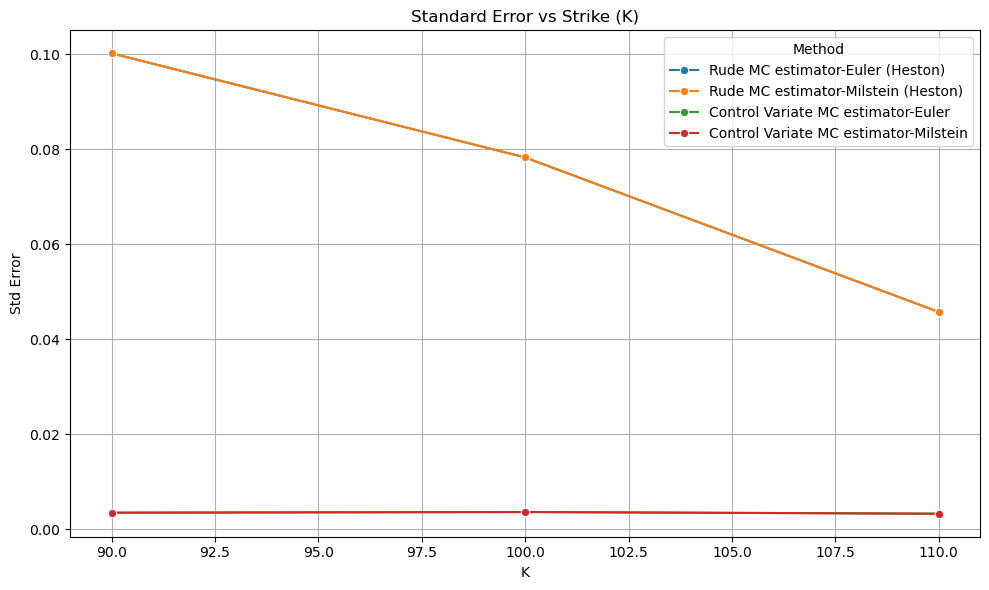

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_K, x="K", y="Std Error", hue="Method", marker="o")
plt.title("Standard Error vs Strike (K)")
plt.grid(True)
plt.tight_layout()
plt.show()

## (c): Additional Analysis

###  impact of averaging frequency

In [20]:
N_values = [1000, 2000, 5000, 10000]
results_list_N = []

for N in N_values:
    result = MC(10000, N, 0.3, -0.2, 100)
    result["N"] = N
    results_list_N.append(result)

df_N = pd.concat(results_list_N)
print(df_N)

Simulating paths: 100%|███████████████████████████████████████████████████████████| 9999/9999 [00:36<00:00, 272.34it/s]


                                  Method     Price  Std Error      N
0       Rude MC estimator-Euler (Heston)  5.662113   0.077173   1000
1    Rude MC estimator-Milstein (Heston)  5.662100   0.077183   1000
2     Control Variate MC estimator-Euler  5.292157   0.003553   1000
3  Control Variate MC estimator-Milstein  5.292157   0.003557   1000
0       Rude MC estimator-Euler (Heston)  5.707865   0.076494   2000
1    Rude MC estimator-Milstein (Heston)  5.707957   0.076501   2000
2     Control Variate MC estimator-Euler  5.291344   0.003408   2000
3  Control Variate MC estimator-Milstein  5.291352   0.003409   2000
0       Rude MC estimator-Euler (Heston)  5.592518   0.075463   5000
1    Rude MC estimator-Milstein (Heston)  5.592698   0.075473   5000
2     Control Variate MC estimator-Euler  5.294133   0.003467   5000
3  Control Variate MC estimator-Milstein  5.294140   0.003468   5000
0       Rude MC estimator-Euler (Heston)  5.620583   0.075623  10000
1    Rude MC estimator-Milstein (H

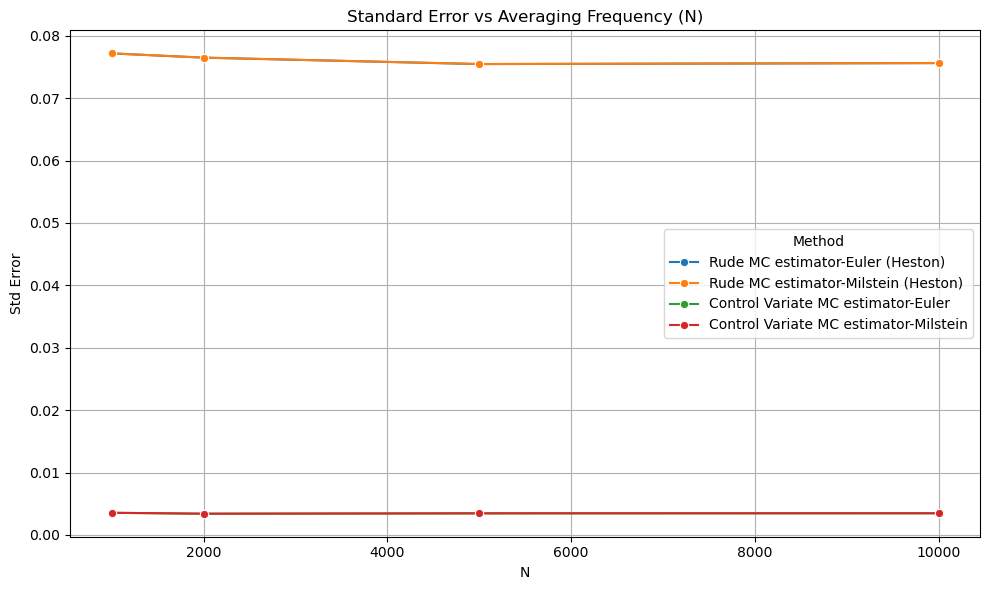

In [21]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_N, x="N", y="Std Error", hue="Method", marker="o")
plt.title("Standard Error vs Averaging Frequency (N)")
plt.grid(True)
plt.tight_layout()
plt.show()